# Test the runtime of IBD calling

In [106]:
import socket as socket
import os as os
import sys as sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from itertools import combinations

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/ibd_euro/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())

#sys.path.append("/n/groups/reich/hringbauer/git/hapBLOCK/python3/") 
#from main import HMM_Full
#from ancIBD.run import hapBLOCK_chrom, run_plot_pair
sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/package/")  # hack to get development package first in path
from ancIBD.run import hapBLOCK_chroms

### hapsburgImport
#sys.path.insert(0,"/n/groups/reich/hringbauer/git/HAPSBURG/package/")
#from hapsburg.PackagesSupport.parallel_runs.helper_functions import combine_individual_data

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the default
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

compute-e-16-233.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/ibd_euro


# Do a single run for one pair

In [2]:
### From the all.v1 run
version = "53.1"
folder_in =  f"/n/groups/reich/hringbauer/git/hapBLOCK/data/hdf5/1240k_v{version}/ch" # for hdf5
path_meta =  f"/n/groups/reich/hringbauer/git/ibd_euro/data/iid_lists/iid_ibd_v{version}.tsv" # for iids

df = pd.read_csv(path_meta, sep="\t")
print(f'Loaded Meta File with {len(df)} Samples')
min_cov = np.min(df["n_cov_snp"])
print(f"Minimum #1240k SNPs: {min_cov}")

Loaded Meta File with 8818 Samples
Minimum #1240k SNPs: 600109


### Test of Single Pair

In [28]:
def time_2samples_wg(iid2):
    """Times two samples for their whole genome.
    Return: Runtime, IBD df"""
    start = time() # Start Clock
    df_ibds = []
    for ch in range(1,23):
        df_ibd = hapBLOCK_chroms(folder_in=folder_in,
                                 iids=iids2, run_iids=[iids2],
                                 ch=ch, folder_out="",
                                 output=False, prefix_out='', logfile=False,
                                 l_model='h5', e_model='haploid_gl2', h_model='FiveStateScaled', 
                                 t_model='standard', p_col="variants/AF_ALL",
                                 ibd_in=1, ibd_out=10, ibd_jump=400,
                                 min_cm=6, cutoff_post=0.99, max_gap=0.0075,
                                 processes=1)
        df_ibds.append(df_ibd)
    df_ibd = pd.concat(df_ibds)
    runtime = time() - start # Runtime in s
    
    
    return runtime, df_ibd

In [39]:
iids2 = df["iid"][:2]
ch = 1
#iids2 = ["I22118", "I22122"]



## A) Do large scale testing of pairs

In [58]:
n = 100

runtimes, sumibd = np.zeros(n), np.zeros(n)
iid1, iid2 = np.zeros(n, dtype="object"), np.zeros(n, dtype="object")

for i in range(n):
    iids2 = np.random.choice(df["iid"], 2)
    iid1[i], iid2[i] = iids2
    runtime, df_ibd = time_2samples_wg(iids2)
    runtimes[i] = runtime
    sumibd[i] = np.sum(df_ibd["lengthM"])
    
dft = pd.DataFrame({"iid1":iid1, "iid2":iid2, "runtime":runtimes, "sumIBD":sumibd})

In [81]:
savepath = "/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/linear100.tsv"
dft.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(dft)} runtimes to: {savepath}")

Saved 100 runtimes to: /n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/linear100.tsv


## B) Do large scale testing of linear loading of pairs

In [88]:
def run_time_random_batch(n=100):
    """Run Time of a Random Batch"""
    print(f"Sample Number: {n}")
    start = time()

    pairs = [np.random.choice(df["iid"], 2) for _ in range(n)]
    iids = list(set(np.concatenate(pairs)))
    
    for ch in range(1,23):
        print(f"Running Chr.: {ch}...")
        df_ibd2 = hapBLOCK_chroms(folder_in=folder_in,
                                     iids=iids, run_iids=pairs,
                                     ch=ch, folder_out="",
                                     output=False, prefix_out='', logfile=False,
                                     l_model='h5', e_model='haploid_gl2', h_model='FiveStateScaled', 
                                     t_model='standard', p_col="variants/AF_ALL",
                                     ibd_in=1, ibd_out=10, ibd_jump=400,
                                     min_cm=6, cutoff_post=0.99, max_gap=0.0075,
                                     processes=1)
    runtime2 = time() - start
    return runtime2

In [ ]:
runtime2 = run_time_random_batch(n=10)

In [84]:
runtime2

261.79200649261475

### Run the actual test

In [ ]:
ns = [2, 5, 10, 20, 50, 100]
runtimes  = [run_time_random_batch(n=n) for n in ns]
dft2 = pd.DataFrame({"#Pairs":ns, "runtime":runtimes})

In [92]:
savepath = "/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs100.tsv"
dft2.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(dft2)} runtimes to: {savepath}")

Saved 6 runtimes to: /n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs100.tsv


## C) Run pairs of samples when loading batch of individuals

In [109]:
def run_time_allpairs(n=10):
    """Run Time of a Random Batch"""
    print(f"Sample Number: {n}")
    start = time()

    iids =  np.random.choice(df["iid"], n)
    pairs = list(combinations(iids, 2))
    print(f"Running {len(pairs)} Pairs of samples when loading {n} IIDs")
    
    for ch in range(1,23):
        print(f"Running Chr.: {ch}...")
        df_ibd2 = hapBLOCK_chroms(folder_in=folder_in,
                                     iids=iids, run_iids=pairs,
                                     ch=ch, folder_out="",
                                     output=False, prefix_out='', logfile=False,
                                     l_model='h5', e_model='haploid_gl2', h_model='FiveStateScaled', 
                                     t_model='standard', p_col="variants/AF_ALL",
                                     ibd_in=1, ibd_out=10, ibd_jump=400,
                                     min_cm=6, cutoff_post=0.99, max_gap=0.0075,
                                     processes=1)
    runtime = time() - start
    return runtime

In [110]:
run_time_allpairs(4)

Sample Number: 4
Running 6 Pairs of samples when loading 4 IIDs
Running Chr.: 1...
Running Chr.: 2...
Running Chr.: 3...
Running Chr.: 4...
Running Chr.: 5...
Running Chr.: 6...
Running Chr.: 7...
Running Chr.: 8...
Running Chr.: 9...
Running Chr.: 10...
Running Chr.: 11...
Running Chr.: 12...
Running Chr.: 13...
Running Chr.: 14...
Running Chr.: 15...
Running Chr.: 16...
Running Chr.: 17...
Running Chr.: 18...
Running Chr.: 19...
Running Chr.: 20...
Running Chr.: 21...
Running Chr.: 22...


41.34640955924988

In [ ]:
ns = np.arange(2,17,2)
runtimes  = [run_time_random_batch(n=n) for n in ns]
dft3 = pd.DataFrame({"#samples":ns, "#pairs":ns*(ns-1)/2, "runtime":runtimes})

In [125]:
savepath = "/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs_batches.tsv"
dft3.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(dft3)} runtimes to: {savepath}")

Saved 8 runtimes to: /n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs_batches.tsv


In [126]:
dft3

,#samples,#pairs,runtime
0,2,1.0,37.615235
1,4,6.0,76.368261
2,6,15.0,116.412563
3,8,28.0,159.284062
4,10,45.0,199.664037
5,12,66.0,220.769371
6,14,91.0,289.073272
7,16,120.0,306.492299


# 2) Plot the runtime

In [129]:
df1 = pd.read_csv("/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/linear100.tsv", sep="\t")
df2 = pd.read_csv("/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs100.tsv", sep="\t")
df3 = pd.read_csv("/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs_batches.tsv", sep="\t")

In [130]:
df3.head()

,#samples,#pairs,runtime
0,2,1.0,37.615235
1,4,6.0,76.368261
2,6,15.0,116.412563
3,8,28.0,159.284062
4,10,45.0,199.664037


Saved to /n/groups/reich/hringbauer/git/hapBLOCK/figs/runtime/runtime_benchmark.pdf


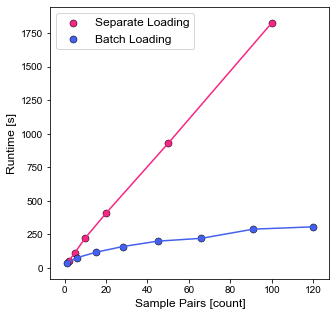

In [176]:
fs=12
lw = .5
s = 50
savepath = "/n/groups/reich/hringbauer/git/hapBLOCK/figs/runtime/runtime_benchmark.pdf"

plt.figure(figsize=(5,5))
ax = plt.gca()

#ax.plot([0,df2["#Pairs"].values[-1]],[0, df2["runtime"].values[-1]], c="gray", linestyle='dashed')
ax.plot(df2["#Pairs"].values, df2["runtime"].values, c="#f72585")
ax.scatter(df2["#Pairs"], df2["runtime"], ec="k", s=s, c="#f72585", label="Separate Loading", lw=lw)

ax.plot(df3["#pairs"].values, df3["runtime"].values, c="#4361ee")
ax.scatter(df3["#pairs"], df3["runtime"], ec="k", s=s, c="#4361ee", label="Batch Loading", lw=lw)

ax.legend(loc="upper left", fontsize=fs)
ax.set_xlabel("Sample Pairs [count]", fontsize=fs)
ax.set_ylabel("Runtime [s]", fontsize=fs)

if len(savepath)>0:
    plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
    print(f"Saved to {savepath}")
    
plt.show()

# Find out Platform CPU

In [82]:
import os, platform, subprocess, re

def get_processor_name():
    if platform.system() == "Windows":
        print("Dindows")
        return platform.processor()
    elif platform.system() == "Linux":
        print("Linux")
        command = "cat /proc/cpuinfo"
        all_info = subprocess.check_output(command, shell=True).decode().strip()
        for line in all_info.split("\n"):
            if "model name" in line:
                return re.sub( ".*model name.*:", "", line,1)
    return ""

In [83]:
get_processor_name()

Linux


' Intel(R) Xeon(R) CPU E5-2697 v3 @ 2.60GHz'

# Area 51